In [196]:
import numpy as np
import pandas as pd
import math
import ptitprince as pt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.5)


import scipy.stats as stats

# Baseline vs follow-up

### load movement quality data

In [197]:
raw_t0 = pd.read_excel('C:/Users/u0117545/Documents/GitHub/ULIFT_BC/MovQual/Output/MoveQual_aff.xlsx', sheet_name = 'T0')
raw_t1 = pd.read_excel('C:/Users/u0117545/Documents/GitHub/ULIFT_BC/MovQual/Output/MoveQual_aff.xlsx', sheet_name = 'T1')
print('No. of baseline: {}, No. of follow-up: {}'.format(len(raw_t0), len(raw_t1)))

No. of baseline: 46, No. of follow-up: 43


In [198]:
# find participants that have T0 and T1 data 
pp_t0 = raw_t0.iloc[:, 0:3].drop('trial', axis = 1)
pp_t1 = raw_t1.iloc[:, 0:3].drop('trial', axis = 1)
pp_list = pd.merge(pp_t0, pp_t1, on='ppID')
pp_list = pp_list.drop(['time_x', 'time_y'], axis = 1)
print('no. of participants with baseline and follow-up measures: {}'.format(len(pp_list)))
print(pp_list)

no. of participants with baseline and follow-up measures: 34
      ppID
0   BC_011
1   BC_012
2   BC_013
3   BC_014
4   BC_015
5   BC_016
6   BC_017
7   BC_018
8   BC_019
9   BC_020
10  BC_023
11  BC_026
12  BC_029
13  BC_031
14  BC_032
15  BC_033
16  BC_034
17  BC_035
18  BC_036
19  BC_037
20  BC_039
21  BC_041
22  BC_042
23  BC_043
24  BC_044
25  BC_045
26  BC_046
27  BC_047
28  BC_048
29  BC_049
30  BC_050
31  BC_051
32  BC_054
33  BC_055


In [199]:
# only retain the participants with both T0 and T1 data
raw_t0 = pd.merge(raw_t0, pp_list, on='ppID')
raw_res_t0 = raw_t0[['ppID', 'time','lyapExp_res', 'sampen_res', 'LDLJ_A', 'reg_res' , 'rms_res']]


raw_t1 = pd.merge(raw_t1, pp_list, on='ppID')
raw_res_t1 = raw_t1[['ppID', 'time','lyapExp_res', 'sampen_res', 'LDLJ_A', 'reg_res' , 'rms_res']]


assert len(raw_t0) == len(raw_t1)

raw = pd.concat([raw_t0, raw_t1], axis=0, ignore_index=True)

# only retain the vector data
raw_res = raw[[ 'time','lyapExp_res', 'sampen_res', 'LDLJ_A', 'reg_res' , 'rms_res']]
raw_res.head()

,time,lyapExp_res,sampen_res,LDLJ_A,reg_res,rms_res
0,T0,4.932879,0.951037,-6.483206,0.615961,4.861625
1,T0,3.473117,1.023576,-7.067763,0.480627,5.040381
2,T0,2.997241,1.210363,-8.265346,0.232062,2.915511
3,T0,2.741568,0.819376,-6.369987,0.653517,5.698095
4,T0,0.674435,1.110880,-6.628168,0.454826,3.852422


### load questionnaire data

In [200]:
raw_questionnaire = pd.read_csv("UPLIFTBC-QuickDASH_DATA_2023-01-05_1222.csv", delimiter='\t')
#QuickDASH data
raw_dash = raw_questionnaire.drop('pain_score', axis =1)
# VAS data
raw_vas = raw_questionnaire[['record_id', 'redcap_event_name', 'pain_score']]

In [201]:
raw_res_t0.head()

,ppID,time,lyapExp_res,sampen_res,LDLJ_A,reg_res,rms_res
0,BC_011,T0,4.932879,0.951037,-6.483206,0.615961,4.861625
1,BC_012,T0,3.473117,1.023576,-7.067763,0.480627,5.040381
2,BC_013,T0,2.997241,1.210363,-8.265346,0.232062,2.915511
3,BC_014,T0,2.741568,0.819376,-6.369987,0.653517,5.698095
4,BC_015,T0,0.674435,1.110880,-6.628168,0.454826,3.852422


In [202]:
# baseline QuickDASH 
idx = raw_dash['redcap_event_name'].str.contains('t0')
mask = np.where(idx)[0]
baseline_dash = raw_dash.iloc[mask]
baseline_dash.head()

,record_id,redcap_event_name,quickdash_1,quickdash_2,quickdash_3,quickdash_4,quickdash_5,quickdash_6,quickdash_7,quickdash_8,quickdash_9,quickdash_10,quickdash_11
0,BC_001,t0_baseline_presur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,BC_002,t0_baseline_presur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,BC_003,t0_baseline_presur_arm_1,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0
10,BC_004,t0_baseline_presur_arm_1,4.0,3.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0
11,BC_005,t0_baseline_presur_arm_1,3.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0


#### QuickDASH analysis

In [217]:
# remove participants with more than 2 NaNs
print("Before removing rows with missing data: {} rows".format(len(baseline_dash)))
df_dash = baseline_dash.dropna(thresh=baseline_dash.shape[1]-1, axis=0)
print("After removing rows with missing data: {} rows".format(len(df_dash)))

som = df_dash.iloc[:,2:].sum(axis='columns')
col_n_counts = np.sum(df_dash.applymap(lambda x: 0 if pd.isnull(x) else 1), axis=1)-2
complete = col_n_counts.apply(lambda x:  x >= 10 )

total_score = ((som/col_n_counts)-1) * 25

print('Average score over all participants and timepoints = {}'.format(np.mean(total_score)))
print('Maximum and minumum scores are {} & {} respectively'.format(total_score.max(), total_score.min()))

#set-up dataframe for total dash scores. 
d = {'ppID': df_dash['record_id'],
    'total_score': total_score}
df_totaldash = pd.DataFrame(data=d)

# find the people with a dash score higher than 15
idx = df_totaldash['total_score'] < 15
mask = np.where(idx)[0]
prePain = df_totaldash.iloc[mask]
prePain = prePain.drop('total_score', axis =1)

Before removing rows with missing data: 64 rows
After removing rows with missing data: 60 rows
Average score over all participants and timepoints = 7.5795454545454515
Maximum and minumum scores are 56.81818181818182 & 0.0 respectively


In [204]:
# select the participants with baseline and follow-up measures with no disability at baseline
pp_list_noPain = pd.merge(prePain, pp_list, on='ppID')
print('No. of people with baseline & follow up measures & without baseline perceived disability: {}'.format(len(pp_list_noPain)))
print(pp_list_noPain)

No. of people with baseline & follow up measures & without baseline perceived disability: 30
      ppID
0   BC_011
1   BC_013
2   BC_014
3   BC_015
4   BC_016
5   BC_017
6   BC_018
7   BC_019
8   BC_023
9   BC_026
10  BC_029
11  BC_031
12  BC_032
13  BC_033
14  BC_034
15  BC_035
16  BC_036
17  BC_037
18  BC_039
19  BC_041
20  BC_042
21  BC_044
22  BC_045
23  BC_046
24  BC_047
25  BC_048
26  BC_050
27  BC_051
28  BC_054
29  BC_055


In [205]:
t0_noPain = pd.merge(raw_res_t0, pp_list_noPain, on='ppID')
t1_noPain = pd.merge(raw_res_t1, pp_list_noPain, on='ppID')

assert len(t0_noPain) == len(t1_noPain) == len(pp_list_noPain)

df_noPain = pd.concat([t0_noPain, t1_noPain], axis=0, ignore_index=True)
df_noPain.head()

,ppID,time,lyapExp_res,sampen_res,LDLJ_A,reg_res,rms_res
0,BC_011,T0,4.932879,0.951037,-6.483206,0.615961,4.861625
1,BC_013,T0,2.997241,1.210363,-8.265346,0.232062,2.915511
2,BC_014,T0,2.741568,0.819376,-6.369987,0.653517,5.698095
3,BC_015,T0,0.674435,1.110880,-6.628168,0.454826,3.852422
4,BC_016,T0,2.743834,1.010746,-6.985151,0.694873,4.771970


In [206]:
# store that data for follow up analysis
%store t1_noPain

Stored 't1_noPain' (DataFrame)


#### chack gausian distribution 

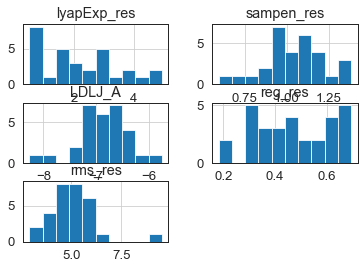

In [207]:
t0_noPain.hist()
plt.show()

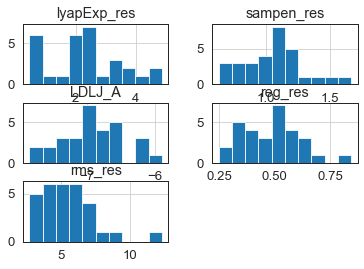

In [208]:
t1_noPain.hist()
plt.show()

Visual inspection showed no normal distribution for most of our data. 
Thus, Non-parametric testing

#### Wilcoxon signed rank test to test for group differences baseline vs follow-up

In [209]:
for var in df_noPain.columns:
    if var == 'ppID' or var == 'time':
        print(80* "_" + "\n" )
        
    else:
        print('Analysing {}'.format(var))
        t_statistic, pvalue = stats.wilcoxon(t0_noPain[var], t1_noPain[var])
        print(round(t_statistic, ndigits=4), round(pvalue, ndigits=4))
        print(80* '_' + '\n')
        

________________________________________________________________________________

________________________________________________________________________________

Analysing lyapExp_res
216.0 0.7343
________________________________________________________________________________

Analysing sampen_res
172.0 0.2134
________________________________________________________________________________

Analysing LDLJ_A
219.0 0.7813
________________________________________________________________________________

Analysing reg_res
206.0 0.5857
________________________________________________________________________________

Analysing rms_res
187.0 0.3493
________________________________________________________________________________



#### Raincloud plot

In [210]:
df_noPain.columns

Index(['ppID', 'time', 'lyapExp_res', 'sampen_res', 'LDLJ_A', 'reg_res',
       'rms_res'],
      dtype='object')

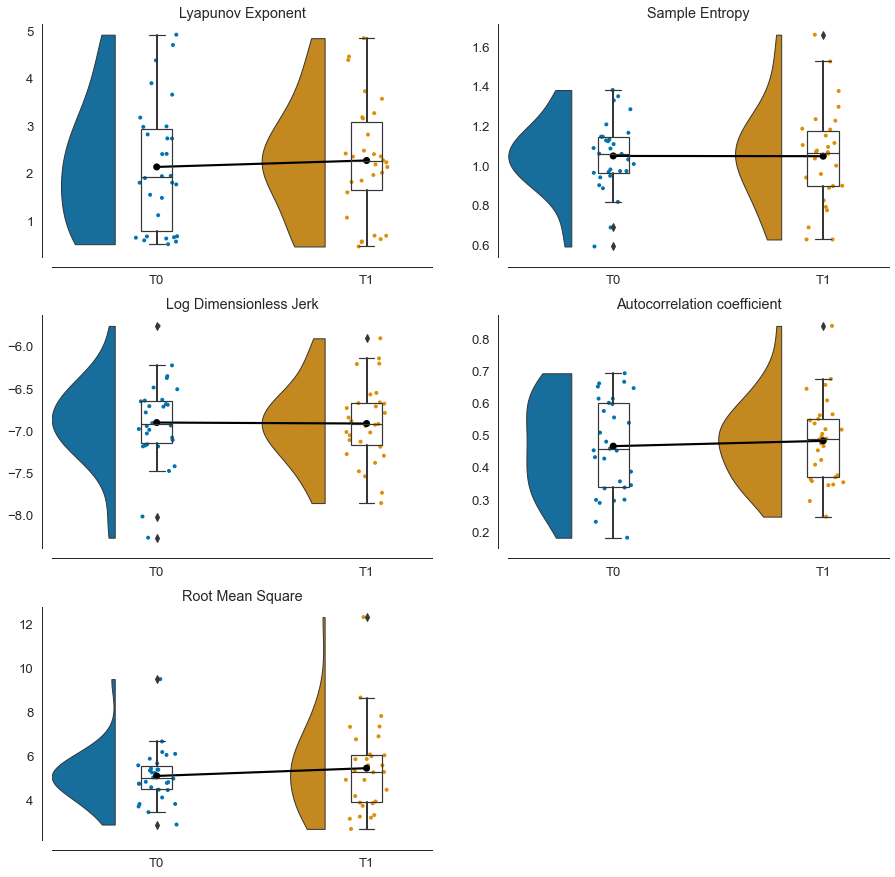

In [211]:
X = df_noPain.drop(['ppID', 'time'], axis=1)
# find minimum required rows given 2 columns
ncols = 2
nrows = math.trunc(len(X.columns) / ncols + (len(X.columns) % ncols > 0))

dx = 'time'; ort = 'v'; pal = 'colorblind'; sigma = 0.6; viol = 0.6; mv = .0; point=4

f = plt.figure(figsize = (15,15))
plt.subplots_adjust(hspace=0.25)

f.tight_layout()

for n, columns in enumerate(X.columns):
    #add a new subplot itteratively
    ax = plt.subplot(nrows, ncols, n+1)
    
    pt.RainCloud(x=dx, y=columns, data=df_noPain, ax=ax, orient = ort,
                palette = pal, bw=sigma, width_viol = viol, move = mv, point_size=point, pointplot=True, 
                 linecolor='black')
    sns.despine(offset=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if n==0:
        ax.set_title('Lyapunov Exponent')
    elif n==1:
        ax.set_title('Sample Entropy')
    elif n==2:
        ax.set_title('Log Dimensionless Jerk')   
    elif n==3:
        ax.set_title('Autocorrelation coefficient')
    elif n==4:
        ax.set_title('Root Mean Square')
        
plt.savefig('C:\\Users\\u0117545\\OneDrive - KU Leuven\\1.Abstract & Papers\\6.0.ULFunctioning\\MovQual\\MovementQuality_res.tiff')

There are no significant differences between baseline and follow-up movement quality 

# Follow-up people with preceived diability vs no perceived disability

### calculate dash scores at follow-up measurement

In [245]:
raw_dash

# follow-up QuickDASH 
idx = raw_dash['redcap_event_name'].str.contains('t1')
mask = np.where(idx)[0]
follow_raw = raw_dash.iloc[mask]

29

In [291]:
# total DASH scores 
# remove participants with more than 2 NaNs
# Remove rows with missing values
print("Before removing rows with missing data: {} rows".format(len(follow_raw)))
df_dash = follow_raw.dropna(thresh=follow_raw.shape[1]-1, axis=0)
print("After removing rows with missing data: {} rows".format(len(df_dash)))

som = df_dash.iloc[:,2:].sum(axis='columns')
col_n_counts = np.sum(df_dash.applymap(lambda x: 0 if pd.isnull(x) else 1), axis=1)-2
complete = col_n_counts.apply(lambda x:  x >= 10 )

total_score = ((som/col_n_counts)-1) * 25

print('Average score over all participants and timepoints = {}'.format(np.mean(total_score)))
print('Maximum and minumum scores are {} & {} respectively'.format(total_score.max(), total_score.min()))

#set-up dataframe for total dash scores. 
d = {'ppID': df_dash['record_id'],
    'total_score': total_score}
df_totaldash = pd.DataFrame(data=d)
df_totaldash

Before removing rows with missing data: 52 rows
After removing rows with missing data: 44 rows
Average score over all participants and timepoints = 21.239669421487605
Maximum and minumum scores are 70.45454545454545 & 0.0 respectively


,ppID,total_score
1,BC_001,0.000000
5,BC_002,20.454545
8,BC_003,15.909091
12,BC_005,29.545455
15,BC_006,0.000000
17,BC_007,52.272727
21,BC_009,13.636364
24,BC_010,65.909091
26,BC_011,0.000000
31,BC_013,9.090909


In [293]:
# combine the dash scores with the movement quality data 
df_totaldash.merge(t1_noPain)

,ppID,total_score,time,lyapExp_res,sampen_res,LDLJ_A,reg_res,rms_res
0,BC_011,0.000000,T1,2.486892,0.900892,-6.707485,0.424824,3.879941
1,BC_013,9.090909,T1,0.618862,1.229253,-7.273135,0.488189,3.966452
2,BC_014,31.818182,T1,1.822404,0.826747,-6.882059,0.491295,4.211295
3,BC_015,59.090909,T1,2.280530,1.154115,-6.137404,0.658816,5.890270
4,BC_016,6.818182,T1,0.691465,0.777321,-7.011247,0.538525,3.766738
5,BC_017,2.272727,T1,0.689695,0.960357,-6.667854,0.296661,5.344648
6,BC_019,31.818182,T1,4.398158,0.629938,-7.732105,0.348165,2.716542
7,BC_023,55.000000,T1,1.971756,0.794004,-7.185895,0.355259,3.913241
8,BC_026,12.500000,T1,1.604722,1.378702,-6.784553,0.467707,5.607092
9,BC_029,20.454545,T1,2.424506,1.662887,-7.854389,0.376879,7.853257


### split the group on perceived disability and no perceived disability

In [286]:
# find the people with a dash score higher than 15
idx = df_totaldash['total_score'] >= 15
mask = np.where(idx)[0]
disabled = df_totaldash.iloc[mask]
disabled.insert(loc=len(disabled.columns),
          column='Group',
          value=0)


# find the people with a dash score lower than 15
idx = df_totaldash['total_score'] < 15
mask = np.where(idx)[0]
not_disabled = df_totaldash.iloc[mask]
not_disabled.insert(loc=len(not_disabled.columns),
                   column = 'Group',
                   value = 1)

print('number of people with perceived disablity: {}'.format(len(disabled)))
print('number of people with no perceived disablity: {}'.format(len(not_disabled)))

number of people with perceived disablity: 10
number of people with no perceived disablity: 13


In [290]:
df_dash

,record_id,redcap_event_name,quickdash_1,quickdash_2,quickdash_3,quickdash_4,quickdash_5,quickdash_6,quickdash_7,quickdash_8,quickdash_9,quickdash_10,quickdash_11
1,BC_001,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,BC_002,t1_1_month_postsur_arm_1,2.0,3.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,1.0
8,BC_003,t1_1_month_postsur_arm_1,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0
12,BC_005,t1_1_month_postsur_arm_1,3.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0
15,BC_006,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17,BC_007,t1_1_month_postsur_arm_1,5.0,3.0,4.0,3.0,1.0,3.0,2.0,3.0,3.0,4.0,3.0
21,BC_009,t1_1_month_postsur_arm_1,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
24,BC_010,t1_1_month_postsur_arm_1,5.0,5.0,4.0,1.0,3.0,3.0,4.0,4.0,4.0,4.0,3.0
26,BC_011,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
31,BC_013,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0
